In [1]:
#print torch version
import torch
print(torch.__version__)

2.5.1+cu121


In [2]:
import torchvision
from torchvision import datasets, transforms
import numpy as np
print(torch.version.cuda)


12.1


In [3]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")


GPU: NVIDIA GeForce RTX 3080 Ti is available.


In [4]:
# Define transformations (resize, normalize, augment)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Load dataset
dataset = datasets.ImageFolder(root=r'C:\Users\Administrator\Desktop\EfficientNet\Augmented_20_Classes', transform=transform)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
#print train and test dataset size

print(len(dataset.classes))
print(len(dataset.imgs)/len(dataset.classes))
print('Train dataset size: ', len(train_dataset))
print('Test dataset size: ', len(test_dataset))

20
1476.0
Train dataset size:  23616
Test dataset size:  5904


In [6]:
import torch.nn as nn
import torchvision.models as models

class LightingRobustCNN(nn.Module):

    def __init__(self, num_classes=1000):
        super(LightingRobustCNN, self).__init__()
        # Use a pre-trained ResNet as the backbone
        self.backbone = models.resnet18(pretrained=True)
        # Replace the final layer for 1000 classes
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Initialize the model
num_classes = len(dataset.classes)
print(num_classes)
model = LightingRobustCNN(num_classes)

20


c:\Users\Administrator\anaconda3\envs\PyTorch-225\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\anaconda3\envs\PyTorch-225\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer

In [8]:
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

cuda
Epoch [1/10], Loss: 0.0192
Epoch [2/10], Loss: 0.0001
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


In [9]:
#print test loader
#print size of test data
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')



Accuracy of the network on the 5904 test images: 100.0%


In [10]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


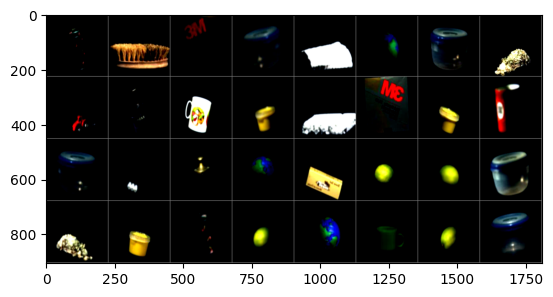

GroundTruth:  5 17 12 0 3 8 0 13 9 1 7
Predicted:  5 17 12 0 3 8 0 13 9 1 7


In [12]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show images and predictions
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(0,11)))
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range(0,11)))

In [13]:
import matplotlib.pyplot as plt

def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

# Get misclassified images
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified_images.append(images[i].cpu())
                misclassified_labels.append(labels[i].cpu())
                misclassified_predictions.append(predicted[i].cpu())

# Show misclassified images
for i in range(len(misclassified_images)):
    imshow(misclassified_images[i], title=f'True: {misclassified_labels[i]}, Predicted: {misclassified_predictions[i]}')
    if i == 9:  # Show only the first 10 misclassified images
        break

In [14]:
#print labels  
print(test_dataset.dataset.classes)
print(misclassified_labels)

['106', '11', '112', '119', '120', '144', '153', '157', '165', '167', '178', '222', '223', '226', '240', '260', '273', '278', '29', '308']
[]
